# Dataset Analysis

Before training our models, we need to understand the quality of our dataset.

## Prerequisite

```sh
python -m venv ~/.venv/lance
source ~/.venv/lance/bin/activate
pip install pylance duckdb matplotlib
```

## Coco Dataset

In this example, we analyze the [Coco dataset](https://cocodataset.org/#home), an object detection dataset.

In [1]:
import lance
import duckdb
import pyarrow as pa

dataset = lance.dataset(
    "s3://eto-public/datasets/coco/coco.lance",
)
dataset.schema


license: int64
file_name: string
coco_url: extension<image[uri]<ImageUriType>>
height: int64
width: int64
date_captured: timestamp[ns]
flickr_url: extension<image[uri]<ImageUriType>>
image_id: int64
split: dictionary<values=string, indices=int8, ordered=0>
image_uri: extension<image[uri]<ImageUriType>>
annotations: struct<segmentation: list<item: struct<counts: list<item: int32>, polygon: list<item: list<item: float>>, size: list<item: int32>>>, area: list<item: double>, iscrowd: list<item: bool>, bbox: list<item: fixed_size_list<item: float>[4]>, category_id: list<item: int16>, id: list<item: int64>, supercategory: list<item: string>, name: list<item: string>>
  child 0, segmentation: list<item: struct<counts: list<item: int32>, polygon: list<item: list<item: float>>, size: list<item: int32>>>
      child 0, item: struct<counts: list<item: int32>, polygon: list<item: list<item: float>>, size: list<item: int32>>
          child 0, counts: list<item: int32>
              child 0, item: 

### Understand Label Distributions

In [2]:
%%time
# Label distribution in training set

duckdb.query("""
SELECT count(1) as count, name 
FROM (
    SELECT UNNEST(annotations.name) AS name FROM dataset
) GROUP BY 2
ORDER BY 1 DESC
""").to_df()

CPU times: user 2.49 s, sys: 819 ms, total: 3.3 s
Wall time: 1min 19s


,count,name
0,273469,person
1,45799,car
2,40282,chair
3,25876,book
4,25367,bottle
...,...,...
75,1517,scissors
76,1365,bear
77,1345,parking meter
78,234,toaster


However, currently `DuckDB` does not support project nested field pushdown, i.e., only reading `annotation.name` column.
We can manually use `Lance`'s PyArrow Scanner integration to selectively read `annotations.name` column.

In [3]:
%%time
scan = dataset.scanner(columns=["annotations.name"])

duckdb.query("""
SELECT count(1) as count, name
FROM (SELECT UNNEST(annotations.name) AS name FROM scan)
GROUP BY 2
ORDER BY 1 DESC
""").to_df()

CPU times: user 595 ms, sys: 114 ms, total: 709 ms
Wall time: 9.32 s


,count,name
0,273469,person
1,45799,car
2,40282,chair
3,25876,book
4,25367,bottle
...,...,...
75,1517,scissors
76,1365,bear
77,1345,parking meter
78,234,toaster


### Calculate Label Distribution among splits



In [10]:
%%time
scan = dataset.scanner(columns=["annotations.name", "split"])

class_count_by_split_df = duckdb.query("""
SELECT
    count(1) as cnt, class, split
FROM (SELECT UNNEST(annotations.name) AS class, split FROM scan)
GROUP BY 3, 2 ORDER BY class, split
""").to_df()
class_count_by_split_df 

CPU times: user 777 ms, sys: 143 ms, total: 920 ms
Wall time: 25.5 s


,cnt,class,split
0,5135,airplane,train
1,143,airplane,val
2,5851,apple,train
3,239,apple,val
4,8720,backpack,train
...,...,...,...
155,277,vase,val
156,7913,wine glass,train
157,343,wine glass,val
158,5303,zebra,train


## Evaluatings skewness of the dataset, between the split

[Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) and [Skewness](https://en.wikipedia.org/wiki/Skewness) are two statistical methods to indicate how imbalance a dataset is. `DuckDB` supports these statistic functions, making dataset balance check quite easy.

In [9]:
%%time
scan = dataset.scanner(columns=["annotations.category_id", "split"])

duckdb.query("""
WITH label_dist AS (
    SELECT  count(1) as cnt, split
    FROM (SELECT UNNEST(annotations.category_id) AS class, split FROM scan)
    GROUP BY split, class
)
SELECT split, entropy(cnt), skewness(cnt) FROM label_dist GROUP BY split
""").to_df()

CPU times: user 730 ms, sys: 64.5 ms, total: 794 ms
Wall time: 10.5 s


,split,entropy(cnt),skewness(cnt)
0,train,6.321928,8.205029
1,val,6.053056,8.101302


The result shows that while `train` and `val` datasets are highly imbalanced, they do share the similar distribution among labels. A picture is worth a thousand words. Let's render the distribution.

<AxesSubplot:xlabel='class'>

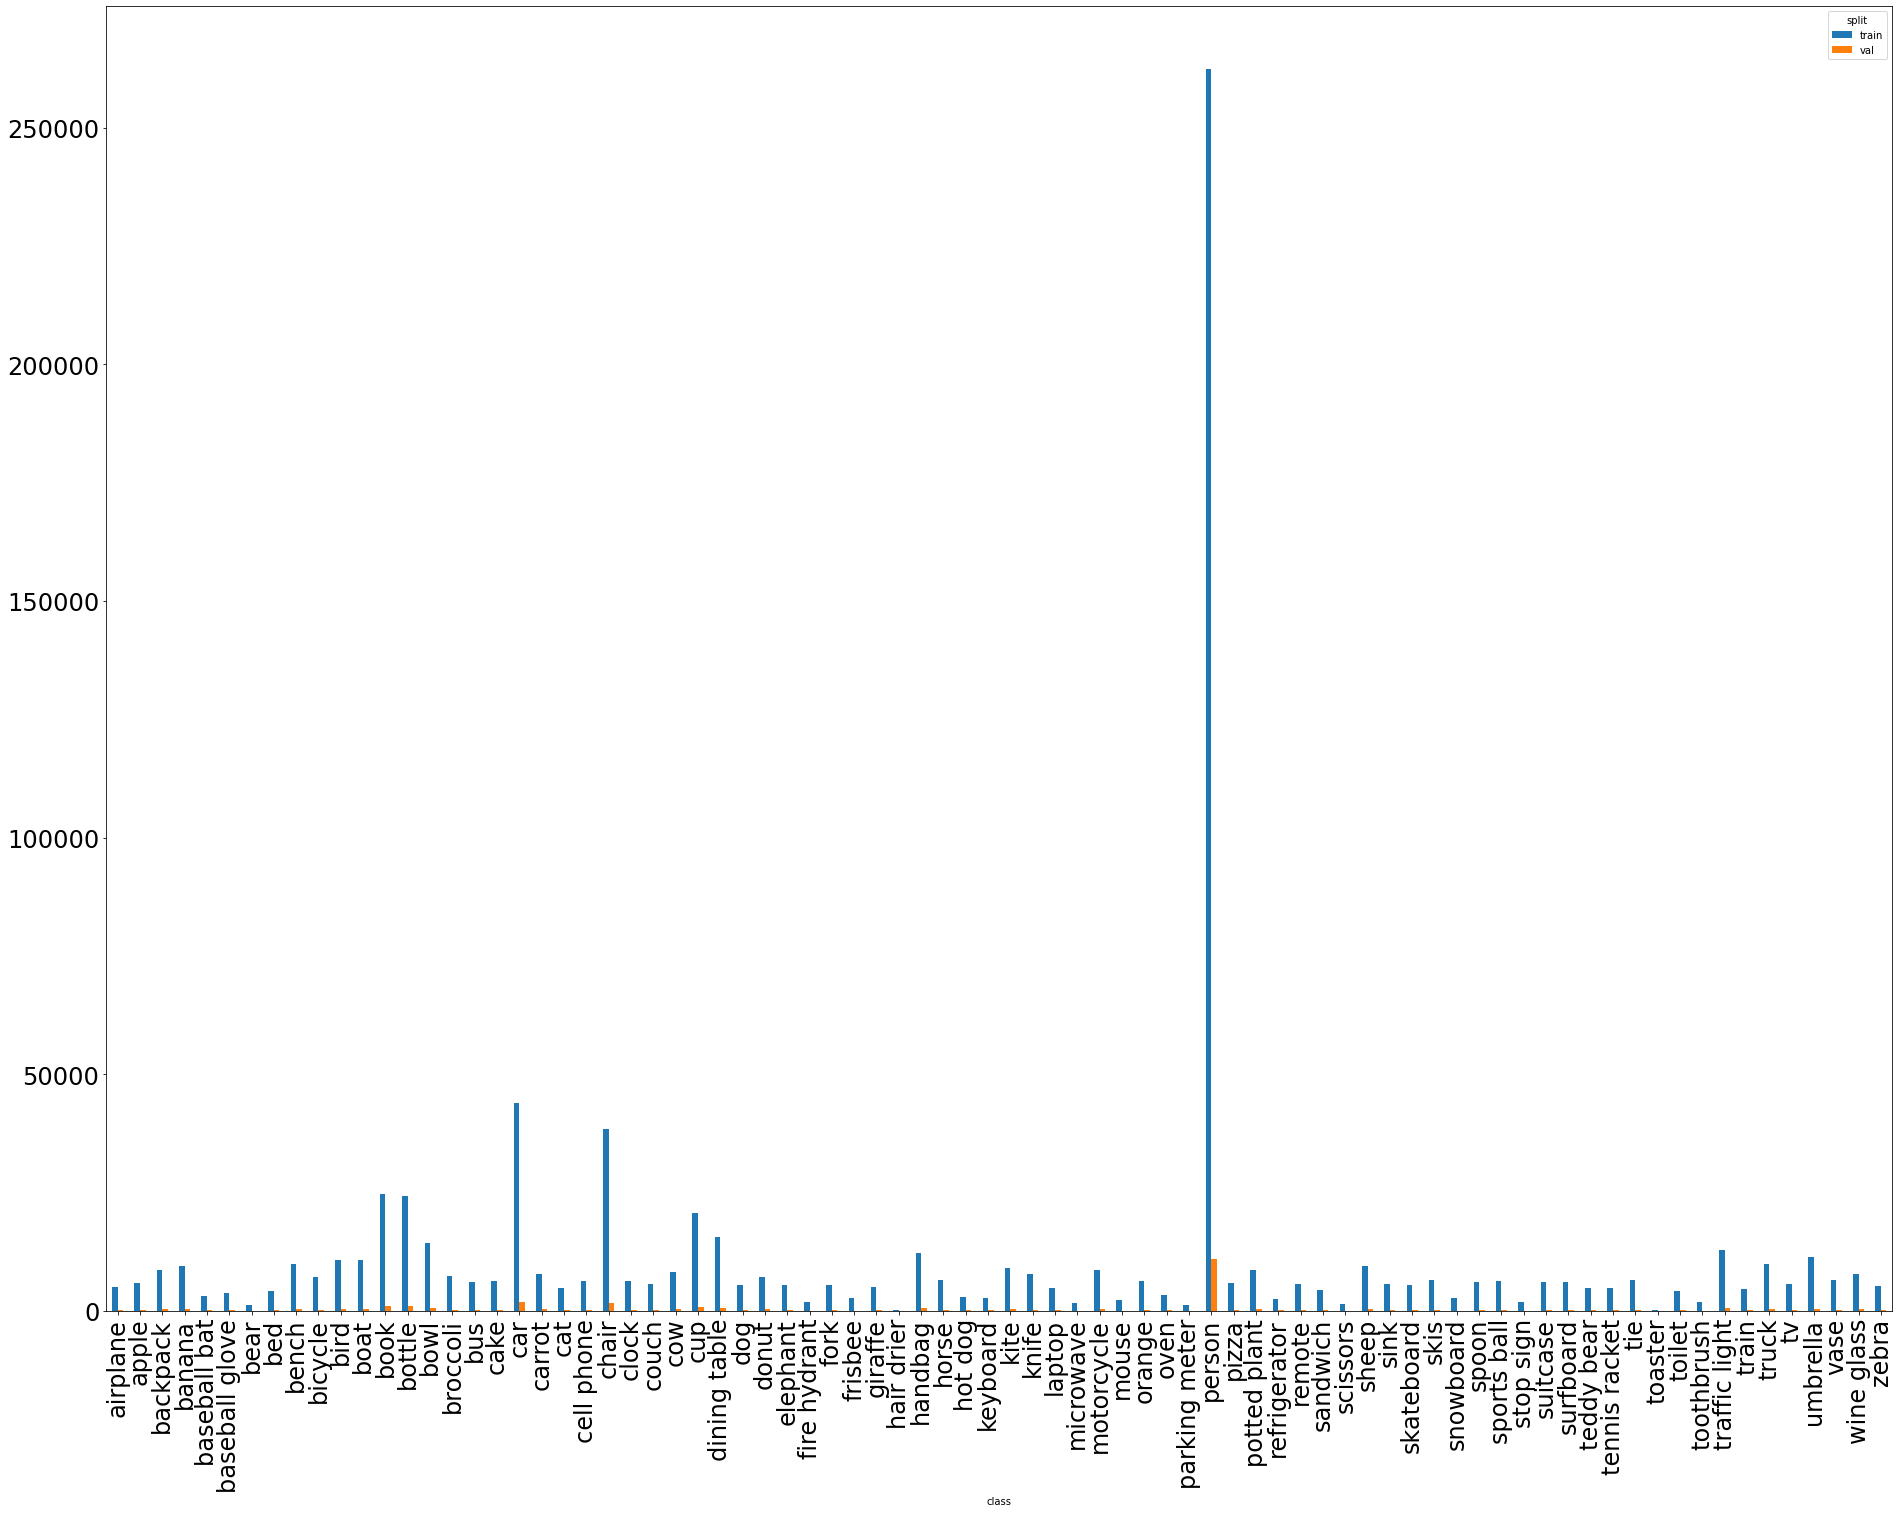

In [61]:
df = class_count_by_split_df.pivot(values='cnt', index='class', columns='split')
df.plot.bar(figsize=(32, 24), fontsize=24)